# ASSIGNMENT 2

**Task 2: Multi Class Classification**

**David Smith** 

**21484971**


## Flow Control 

Below are a series of booleans that allow you to choose what runs and what doesn't depending on what you are interesting in. 


In [1]:
class FunctionsToRun: 
    ## Base true as place holder
    true = True

## Use this function to conditionally run cells 
functions_to_run = FunctionsToRun()

## Environment Setup

### Install dependencies

In [2]:
# !pip install panadas

### Import Core Libraries 


In [3]:
## Import Required Libraries
import os
import re
import json
import string
import pandas as pd 
import numpy as np
from argparse import Namespace
from collections import Counter
from tqdm import tqdm_notebook


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [4]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### Setup figures and output 

In [5]:
## Suppress warning messages 
import warnings
warnings.filterwarnings('ignore')

## Import Graphics Libraries 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

## Setup Colour Scheme 
sns.set_palette("tab10")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", palette="pastel",  rc=custom_params)

## Allows for multiple outputs from cells without having to repeatedly write display 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Set the size of the plots 
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # Note: 200 e.g. is really fine, but slower

def print_heading(text: str):
    print("-"*100)
    print(text.rjust(int(50 + len(text)/2) , " "))
    print("-"*100 , "\n")  

#### Setup Utilities

In [6]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        


# Task 2: Multi-class Document Classification 

## Select Model & Data Type

Use the values below to select what model, data type and word embeddings you wish to use for the modeling phase. 

Note: Lists indexes are 0 based.

For Example: 

Selecting:
- model 1, data_index 1, & embedding index 2 

Would return: 
- 'GRU' for the top ten 'filtered words' using the domain trained 'Word2Vector' embeddings 

In [7]:
## Select model, Vectorization, and data type 
model_index = 2
data_index= 1
embedding_index= 1

## Options to choose from 
models = ["RNN", "GRU", "LSTM"]
data_types = ["full_des" , "filterd_words"]
embedding_types = ["OneHot" , "GloVe" , "Word2Vec"]

In [8]:
## Setup functions 
def select_model():
    return models[model_index]

def select_processed_data_type():
    return data_types[data_index]

def select_embedding():
    return embedding_types[embedding_index]

def set_csv_path():
    # return f"data/ag_seek/{data_types[data_index]}/seek_with_splits.csv" 
    return f"data/seek_data/seek_data_multi_{data_types[data_index]}.csv" 

def set_model_output_location():
    return f"model_storage/{models[model_index]}/{data_types[data_index]}"


## Key Arguments 

Below are some of the key modeling & workflow parameters. I have made an effort to try to ensure that most values can be set here rather than later on in the code. 

In [9]:
args = Namespace(
    # Model Selections
    model = select_model(),
    embedding_type = select_embedding(),
    data_set = select_processed_data_type(),
    save_embeddings = False,
    save_model = False,

    # Data and Path hyper parameters
    seek_csv= set_csv_path(),
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir=set_model_output_location(),

    # Model hyper parameters
    glove_filepath='data/glove/glove.6B.100d.txt', 
    trained_embed_filepath="data/trained_embeddings/model.bin", 
    use_glove=False,
    embedding_size=100, 
    hidden_dim=64, 
    num_channels=100, 
    
    # Training hyper parameter
    seed=42, 
    learning_rate=1e-3,
    dropout_p=0.1, 
    batch_size=128, 
    num_epochs=100, 
    early_stopping_criteria=5, 

    # Runtime option
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
) 

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
    
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)




Expanded filepaths: 
	model_storage/LSTM/filterd_words\vectorizer.json
	model_storage/LSTM/filterd_words\model.pth
Using CUDA: False


## Vocabulary, Vectorizer, Dataset

### Data Vectorization classes

#### The Vocabulary

In [10]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [11]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

#### The Vectorizer

In [12]:
class SeekVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, title_vocab, category_vocab):
        self.title_vocab = title_vocab
        self.category_vocab = category_vocab

    def vectorize(self, x_case_words, vector_length=-1):
        """
        Args:
            x_case_words (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vetorized x_case_words (numpy.array)
        """
        
        indices = [self.title_vocab.begin_seq_index]
        indices.extend(self.title_vocab.lookup_token(token) 
                       for token in x_case_words.split(" "))
        indices.append(self.title_vocab.end_seq_index)


        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.title_vocab.mask_index

        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, seek_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            seek_df (pandas.DataFrame): the target dataset
            cutoff (int): frequency threshold for including in Vocabulary 
        Returns:
            an instance of the SeekVectorizer
        """
        category_vocab = Vocabulary()        
        for category in sorted(set(seek_df.category)):
            category_vocab.add_token(category)

        word_counts = Counter()
        for x_case_words in seek_df.x_case_words:
            for token in x_case_words.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        title_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                title_vocab.add_token(word)
        
        return cls(title_vocab, category_vocab)

    @classmethod
    def from_serializable(cls, contents):
        title_vocab = \
            SequenceVocabulary.from_serializable(contents['title_vocab'])
        category_vocab =  \
            Vocabulary.from_serializable(contents['category_vocab'])

        return cls(title_vocab=title_vocab, category_vocab=category_vocab)

    def to_serializable(self):
        return {'title_vocab': self.title_vocab.to_serializable(),
                'category_vocab': self.category_vocab.to_serializable()}

#### The Dataset

In [13]:
class SeekDataset(Dataset):
    def __init__(self, seek_df, vectorizer):
        """
        Args:
            seek_df (pandas.DataFrame): the dataset
            vectorizer (SeekVectorizer): vectorizer instatiated from dataset
        """
        self.seek_df = seek_df
        self._vectorizer = vectorizer

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, seek_df.x_case_words)) + 2
        

        self.train_df = self.seek_df[self.seek_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.seek_df[self.seek_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.seek_df[self.seek_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # Class weights
        class_counts = seek_df.category.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, seek_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
             csv (str): location of the dataset
        Returns:
            an instance of SeekDataset
        """
        seek_df = pd.read_csv(seek_csv , error_bad_lines=True)
        train_seek_df = seek_df[seek_df.split=='train']
        return cls(seek_df, SeekVectorizer.from_dataframe(train_seek_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, seek_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            Seek_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SeekDataset
        """
        seek_df = pd.read_csv(seek_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(seek_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SeekVectorizer
        """
        with open(vectorizer_filepath, errors='ignore') as fp:
            return SeekVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath,  "w", errors='ignore' ) as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        # title_vector = \
        #     self._vectorizer.vectorize(row.x_case_words, self._max_seq_length)
        
        title_vector, vec_length = \
            self._vectorizer.vectorize(row.x_case_words, self._max_seq_length)
        
        category_index = \
            self._vectorizer.category_vocab.lookup_token(row.category)

        return {'x_data': title_vector,
                'y_target': category_index, 
                'x_length': vec_length}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

def data_loader(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
                     return  DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)


## Make Embeddings Functions 

In [14]:
def load_glove_from_file(glove_filepath):
    """
    Load the GloVe embeddings 
    
    Args:
        glove_filepath (str): path to the glove embeddings file 
    Returns:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r" , errors='ignore') as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

def make_trained_embedding_matrix(embeddings_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        embeddings_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    ##
    from gensim.models import Word2Vec
    # load model
    loaded_model = Word2Vec.load(embeddings_filepath) 
    X = loaded_model[loaded_model.wv.vocab]
    embedding_size = X.shape[1]
    final_embeddings = np.zeros((len(words), embedding_size))
    for i, word in enumerate(words):
        if word in loaded_model.wv.vocab:
            final_embeddings[i, :] = loaded_model[word]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

## PyTorch Setup Functions 

### Data Vectorization classes

## The Model: Category Classifier 


### RNN

In [15]:

def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)

class ElmanRNN(nn.Module):
    """ an Elman RNN built using the RNNCell """
    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        Args:
            input_size (int): size of the input vectors
            hidden_size (int): size of the hidden state vectors
            bathc_first (bool): whether the 0th dimension is batch
        """
        super(ElmanRNN, self).__init__()
        
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        """The forward pass of the ElmanRNN
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                If self.batch_first: x_in.shape = (batch, seq_size, feat_size)
                Else: x_in.shape = (seq_size, batch, feat_size)
            initial_hidden (torch.Tensor): the initial hidden state for the RNN
        Returns:
            hiddens (torch.Tensor): The outputs of the RNN at each time step. 
                If self.batch_first: hiddens.shape = (batch, seq_size, hidden_size)
                Else: hiddens.shape = (seq_size, batch, hidden_size)
        """
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens


class SeekClassifier_RNN(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0, pretrained_embeddings=None):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector 
                Note: the number of nationalities
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will 
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding; 
                see torch.nn.Embedding
        """
        super(SeekClassifier_RNN, self).__init__()
        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        

        # self.emb = nn.Embedding(num_embeddings=num_embeddings,
        #                         embedding_dim=embedding_size,
        #                         padding_idx=padding_idx)
        self.rnn = ElmanRNN(input_size=embedding_size,
                             hidden_size=rnn_hidden_size,
                             batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)
        y_out = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

### GRU

In [16]:

def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)

class GRU_RNN(nn.Module):
    """ an Elman RNN built using the RNNCell """
    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        Args:
            input_size (int): size of the input vectors
            hidden_size (int): size of the hidden state vectors
            bathc_first (bool): whether the 0th dimension is batch
        """
        super(GRU_RNN, self).__init__()
        
        self.rnn_cell = nn.GRUCell(input_size, hidden_size)
        
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        """The forward pass of the ElmanRNN
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                If self.batch_first: x_in.shape = (batch, seq_size, feat_size)
                Else: x_in.shape = (seq_size, batch, feat_size)
            initial_hidden (torch.Tensor): the initial hidden state for the RNN
        Returns:
            hiddens (torch.Tensor): The outputs of the RNN at each time step. 
                If self.batch_first: hiddens.shape = (batch, seq_size, hidden_size)
                Else: hiddens.shape = (seq_size, batch, hidden_size)
        """
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens


class SeekClassifier_GRU(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0, pretrained_embeddings=None):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector 
                Note: the number of nationalities
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will 
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding; 
                see torch.nn.Embedding
        """
        super(SeekClassifier_GRU, self).__init__()
        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        

        # self.emb = nn.Embedding(num_embeddings=num_embeddings,
        #                         embedding_dim=embedding_size,
        #                         padding_idx=padding_idx)
        self.rnn = GRU_RNN(input_size=embedding_size,
                             hidden_size=rnn_hidden_size,
                             batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)
        y_out = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

### LSTM

In [17]:
class LSTM_RNN(nn.Module):
    """ an Elman RNN built using the RNNCell """
    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        Args:
            input_size (int): size of the input vectors
            hidden_size (int): size of the hidden state vectors
            bathc_first (bool): whether the 0th dimension is batch
        """
        super(LSTM_RNN, self).__init__()
        
        self.rnn_cell = nn.LSTMCell(input_size, hidden_size)
        
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        """The forward pass of the ElmanRNN
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                If self.batch_first: x_in.shape = (batch, seq_size, feat_size)
                Else: x_in.shape = (seq_size, batch, feat_size)
            initial_hidden (torch.Tensor): the initial hidden state for the RNN
        Returns:
            hiddens (torch.Tensor): The outputs of the RNN at each time step. 
                If self.batch_first: hiddens.shape = (batch, seq_size, hidden_size)
                Else: hiddens.shape = (seq_size, batch, hidden_size)
        """
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens


class SeekClassifier_LSTM(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0, pretrained_embeddings=None):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector 
                Note: the number of nationalities
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will 
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding; 
                see torch.nn.Embedding
        """
        super(SeekClassifier_LSTM, self).__init__()
        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        

        # self.emb = nn.Embedding(num_embeddings=num_embeddings,
        #                         embedding_dim=embedding_size,
        #                         padding_idx=padding_idx)
        self.rnn = GRU_RNN(input_size=embedding_size,
                             hidden_size=rnn_hidden_size,
                             batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)
        y_out = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

## Training Routine

### Training Setup functions

In [18]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria
        ## Save Embeddings 
        if args.save_embeddings:
            save_embeddings(embeddings)

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

embedding_path = f"./{args.save_dir}/{args.data_set}_embeddings.txt" 
 
def save_embeddings(embeddings):
    if embeddings is None: 
        return
    with open(embedding_path , "w") as f:
          f.write(json.dumps(embeddings.tolist()))

def load_embeddings(path):
    #Now read the file back into a Python list object
    with open(path, 'r') as f:
        a = json.loads(f.read())
        return np.array(a)

### Initializations & Embedding Selection

In [19]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SeekDataset.load_dataset_and_load_vectorizer(args.seek_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SeekDataset.load_dataset_and_make_vectorizer(args.seek_csv)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

## Select the embeddings type 
if args.embedding_type == "GloVe":
    words = vectorizer.title_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
elif args.embedding_type == "Word2Vec":
    words = vectorizer.title_vocab._token_to_idx.keys()
    embeddings = make_trained_embedding_matrix(args.trained_embed_filepath, 
                                       words=words)
    print("Using trained embeddings")
else:
    print("Using one-hot embeddings")
    embeddings = None


if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # training from a checkpoint
    dataset = SeekDataset.load_dataset_and_load_vectorizer(args.seek_csv, 
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SeekDataset.load_dataset_and_make_vectorizer(args.seek_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()




Using pre-trained embeddings


### Model Selection

In [20]:
if args.model == "RNN":
    print_heading("Using RNN Model")
    classifier = SeekClassifier_RNN(embedding_size=args.embedding_size, 
                               num_embeddings=len(vectorizer.title_vocab),
                               num_classes=len(vectorizer.category_vocab),
                               rnn_hidden_size=args.hidden_dim,
                               padding_idx=vectorizer.title_vocab.mask_index, 
                                pretrained_embeddings=embeddings,
                                )
elif args.model == "GRU":
    print_heading("Using GRU Model")
    classifier = SeekClassifier_GRU(embedding_size=args.embedding_size, 
                               num_embeddings=len(vectorizer.title_vocab),
                               num_classes=len(vectorizer.category_vocab),
                               rnn_hidden_size=args.hidden_dim,
                               padding_idx=vectorizer.title_vocab.mask_index, 
                                pretrained_embeddings=embeddings,
                                )
elif args.model == "LSTM":
    print_heading("Using LSTM Model")
    classifier = SeekClassifier_LSTM(embedding_size=args.embedding_size, 
                               num_embeddings=len(vectorizer.title_vocab),
                               num_classes=len(vectorizer.category_vocab),
                               rnn_hidden_size=args.hidden_dim,
                               padding_idx=vectorizer.title_vocab.mask_index, 
                                pretrained_embeddings=embeddings,
                                )
    
classifier.state_dict

----------------------------------------------------------------------------------------------------
                                          Using GRU Model
---------------------------------------------------------------------------------------------------- 



<bound method Module.state_dict of SeekClassifier_LSTM(
  (emb): Embedding(486, 100, padding_idx=0)
  (rnn): GRU_RNN(
    (rnn_cell): GRUCell(100, 64)
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=30, bias=True)
)>

## Training Loops

### RNN. GRU & LSTM Training Loop

In [ ]:

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                        mode='min', factor=0.5,
                                        patience=1)
train_state = make_train_state(args)
epoch_bar = tqdm_notebook(desc='training routine', 
                        total=args.num_epochs,
                        position=0)
dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

if args.save_embeddings:
    save_embeddings(embeddings)
    
try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index
        # Iterate over training dataset
        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                        batch_size=args.batch_size, 
                                        device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:
            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()
            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])
            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            # step 4. use loss to produce gradients
            loss.backward()
            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)
        # Iterate over val dataset
        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                        batch_size=args.batch_size, 
                                        device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()
        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])
            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()
        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        train_state = update_train_state(args=args, model=classifier, 
                                        train_state=train_state)
        scheduler.step(train_state['val_loss'][-1])
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("Exiting loop")

## Model Comparisons 

### Setup Functions 

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, f1_score , accuracy_score
from sklearn.metrics import confusion_matrix 

## Set the size of the plots 
plt.rcParams['figure.figsize'] = [18, 14]
plt.rcParams['figure.dpi'] = 200 # Note: 200 e.g. is really fine, but slower

## Setup data fields 
class_names = range(0,30)

## Function that creates a confusion matrix plot 
def create_confusion_plot(conf_mx , y_values , name ="" , force_shape = 30):
  ## Format the value from matrix
  group_counts = ["{0:0.0f}".format(value) for value in
                  conf_mx .flatten()]
                  
  ## Get the percentage of represented in each cell
  group_percentages = ["{0:.2%}".format(value) for value in
                      conf_mx .flatten()/np.sum(conf_mx )]
  ## Create Text Labels 
  labels = [f"{v1}\n{v2}" for v1, v2 in
            zip(group_counts,group_percentages)]

  ## Reshape the array into a data frame 
  n_classes = len(np.unique(y_values))
  # n_classes = force_shape
  
  labels = np.asarray(labels).reshape(n_classes , n_classes)

  ## Create colour palette
  cmap = 'Blues'

  ## Create new plot
  plt.figure() 
  ## Create heatmap
  # res = sns.heatmap(conf_mx , annot=labels ,fmt='',  vmin=0.0, vmax= 100.0,  cmap=cmap)
  res = sns.heatmap(conf_mx , annot=labels ,fmt='', annot_kws={"size": 6},    cmap=cmap)

  # labels, title and ticks
  res.set_xlabel('Predicted labels')
  res.set_ylabel('True labels')
  res.set_title(name + " Class Confusion Matrix", fontsize=18)
  res.xaxis.set_ticklabels( [class_names[i] for i in  np.unique(y_values)] )
  res.yaxis.set_ticklabels([class_names[i] for i in  np.unique(y_values)] )
  plt.yticks(rotation=0) 
  plt.plot()

## Function to quickly create model evaluations 
def evaluate_torch_model(y_target, y_pred, name=""):
    # print("\n\n---------------------------- Model Results ----------------------------\n")
    # print_heading("Model Results")
    ## Create Prediction from testing data 
    # y_prob = model.predict(x_data)
    # y_pred = y_prob.argmax(axis=-1)

    ## Calculate individual scores
    print(name , " Accuracy Score: " , "{0:.2%}".format(accuracy_score(y_target, y_pred)))
    print(name , " Precision Score: " , "{0:.2%}".format(precision_score(y_target, y_pred, average="weighted")))
    print(name , " Recall Score: " , "{0:.2%}".format(recall_score(y_target, y_pred, average="weighted")))
    print(name , " F1 Score: " , "{0:.2%}".format(f1_score(y_target, y_pred, average="weighted")))

    ## Classification performance 
    report = classification_report(y_target, y_pred)
    print_heading("Classification Report")
    print(report)

    ## Create confusion matrix - no need to print as its on the plot
    conf_mx = confusion_matrix( y_target , y_pred )
    print(conf_mx.shape)
    print_heading("Confusion Matrix")
    create_confusion_plot(conf_mx , y_target,  name )

def influential_words(model , number, reverse , model_name=""):
    # Sort weights
    fc1_weights = model.fc1.weight.to('cpu').detach()[0]
    _, indices = torch.sort(fc1_weights, dim=0, descending=True)
    indices = indices.numpy().tolist()
    direction = "Positive"
    if reverse:
      indices.reverse
      direction = "Negative"
    print_heading(f"{model_name} Influential Words in {direction} Reviews:")
    for i in range(number):
        print(vectorizer.title_vocab.lookup_index(indices[i]))

### Loading & Utility Functions 

In [24]:
def get_text_length(path):
    df = pd.read_csv(path)
    return len(df[df.split == "test"])

def load_model_from_file(path):
    
    ## Get path & model information 
    model_name = path.split("/")[1]
    data_type = path.split("/")[2]
    model_path = path + "final_model.pth"
    csv_path = f"./data/seek_data/seek_data_multi_{data_type}.csv"

    ## Set Seed 
    meaning_of_life = 42
    np.random.seed(meaning_of_life)
    torch.manual_seed(meaning_of_life)

    # create dataset and vectorizer
    dataset = SeekDataset.load_dataset_and_make_vectorizer(csv_path)
    vectorizer = dataset.get_vectorizer()

    ## Load Embeddings 
    embeddings = load_embeddings(f"./{path}/{data_type}_embeddings.txt")
    
    if model_name == "RNN":
            classifier = SeekClassifier_RNN(embedding_size=args.embedding_size, 
                               num_embeddings=len(vectorizer.title_vocab),
                               num_classes=len(vectorizer.category_vocab),
                               rnn_hidden_size=args.hidden_dim,
                               padding_idx=vectorizer.title_vocab.mask_index, 
                                pretrained_embeddings=embeddings,
                                )
    elif model_name == "GRU":
            classifier = SeekClassifier_GRU(embedding_size=args.embedding_size, 
                               num_embeddings=len(vectorizer.title_vocab),
                               num_classes=len(vectorizer.category_vocab),
                               rnn_hidden_size=args.hidden_dim,
                               padding_idx=vectorizer.title_vocab.mask_index, 
                                pretrained_embeddings=embeddings,
                                )
    elif model_name == "LSTM":
            classifier = SeekClassifier_LSTM(embedding_size=args.embedding_size, 
                               num_embeddings=len(vectorizer.title_vocab),
                               num_classes=len(vectorizer.category_vocab),
                               rnn_hidden_size=args.hidden_dim,
                               padding_idx=vectorizer.title_vocab.mask_index, 
                                pretrained_embeddings=embeddings,
                                )

    classifier.load_state_dict(torch.load(model_path))
    classifier = classifier.to(args.device)
    dataset.class_weights = dataset.class_weights.to(args.device)
    
    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                    batch_size=get_text_length(csv_path), 
                                    device=args.device)
    classifier.eval()
    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred = classifier(x_in=batch_dict['x_data'])
        y_data = batch_dict['y_target'].detach().numpy()
        _, y_pred_indices = y_pred.max(dim=1)
        y_pred_indices = y_pred_indices.detach().numpy()
           
    print_heading( f"Model Outcomes: {model_name} {data_type}" )
    evaluate_torch_model(y_data, y_pred_indices, model_name)
                
    return classifier


## RNN: Top 10 Filtered TF-IDF Classification 

----------------------------------------------------------------------------------------------------
                                 Model Outcomes: RNN filterd_words
---------------------------------------------------------------------------------------------------- 

RNN  Accuracy Score:  5.27%
RNN  Precision Score:  6.92%
RNN  Recall Score:  5.27%
RNN  F1 Score:  5.33%
----------------------------------------------------------------------------------------------------
                                       Classification Report
---------------------------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.06      0.03      0.04        32
           1       0.43      0.31      0.36        61
           2       0.12      0.03      0.05       106
           3       0.10      0.06      0.08        81
           4       0.06      0.05      0.05        44
           5       0.00      0.00 

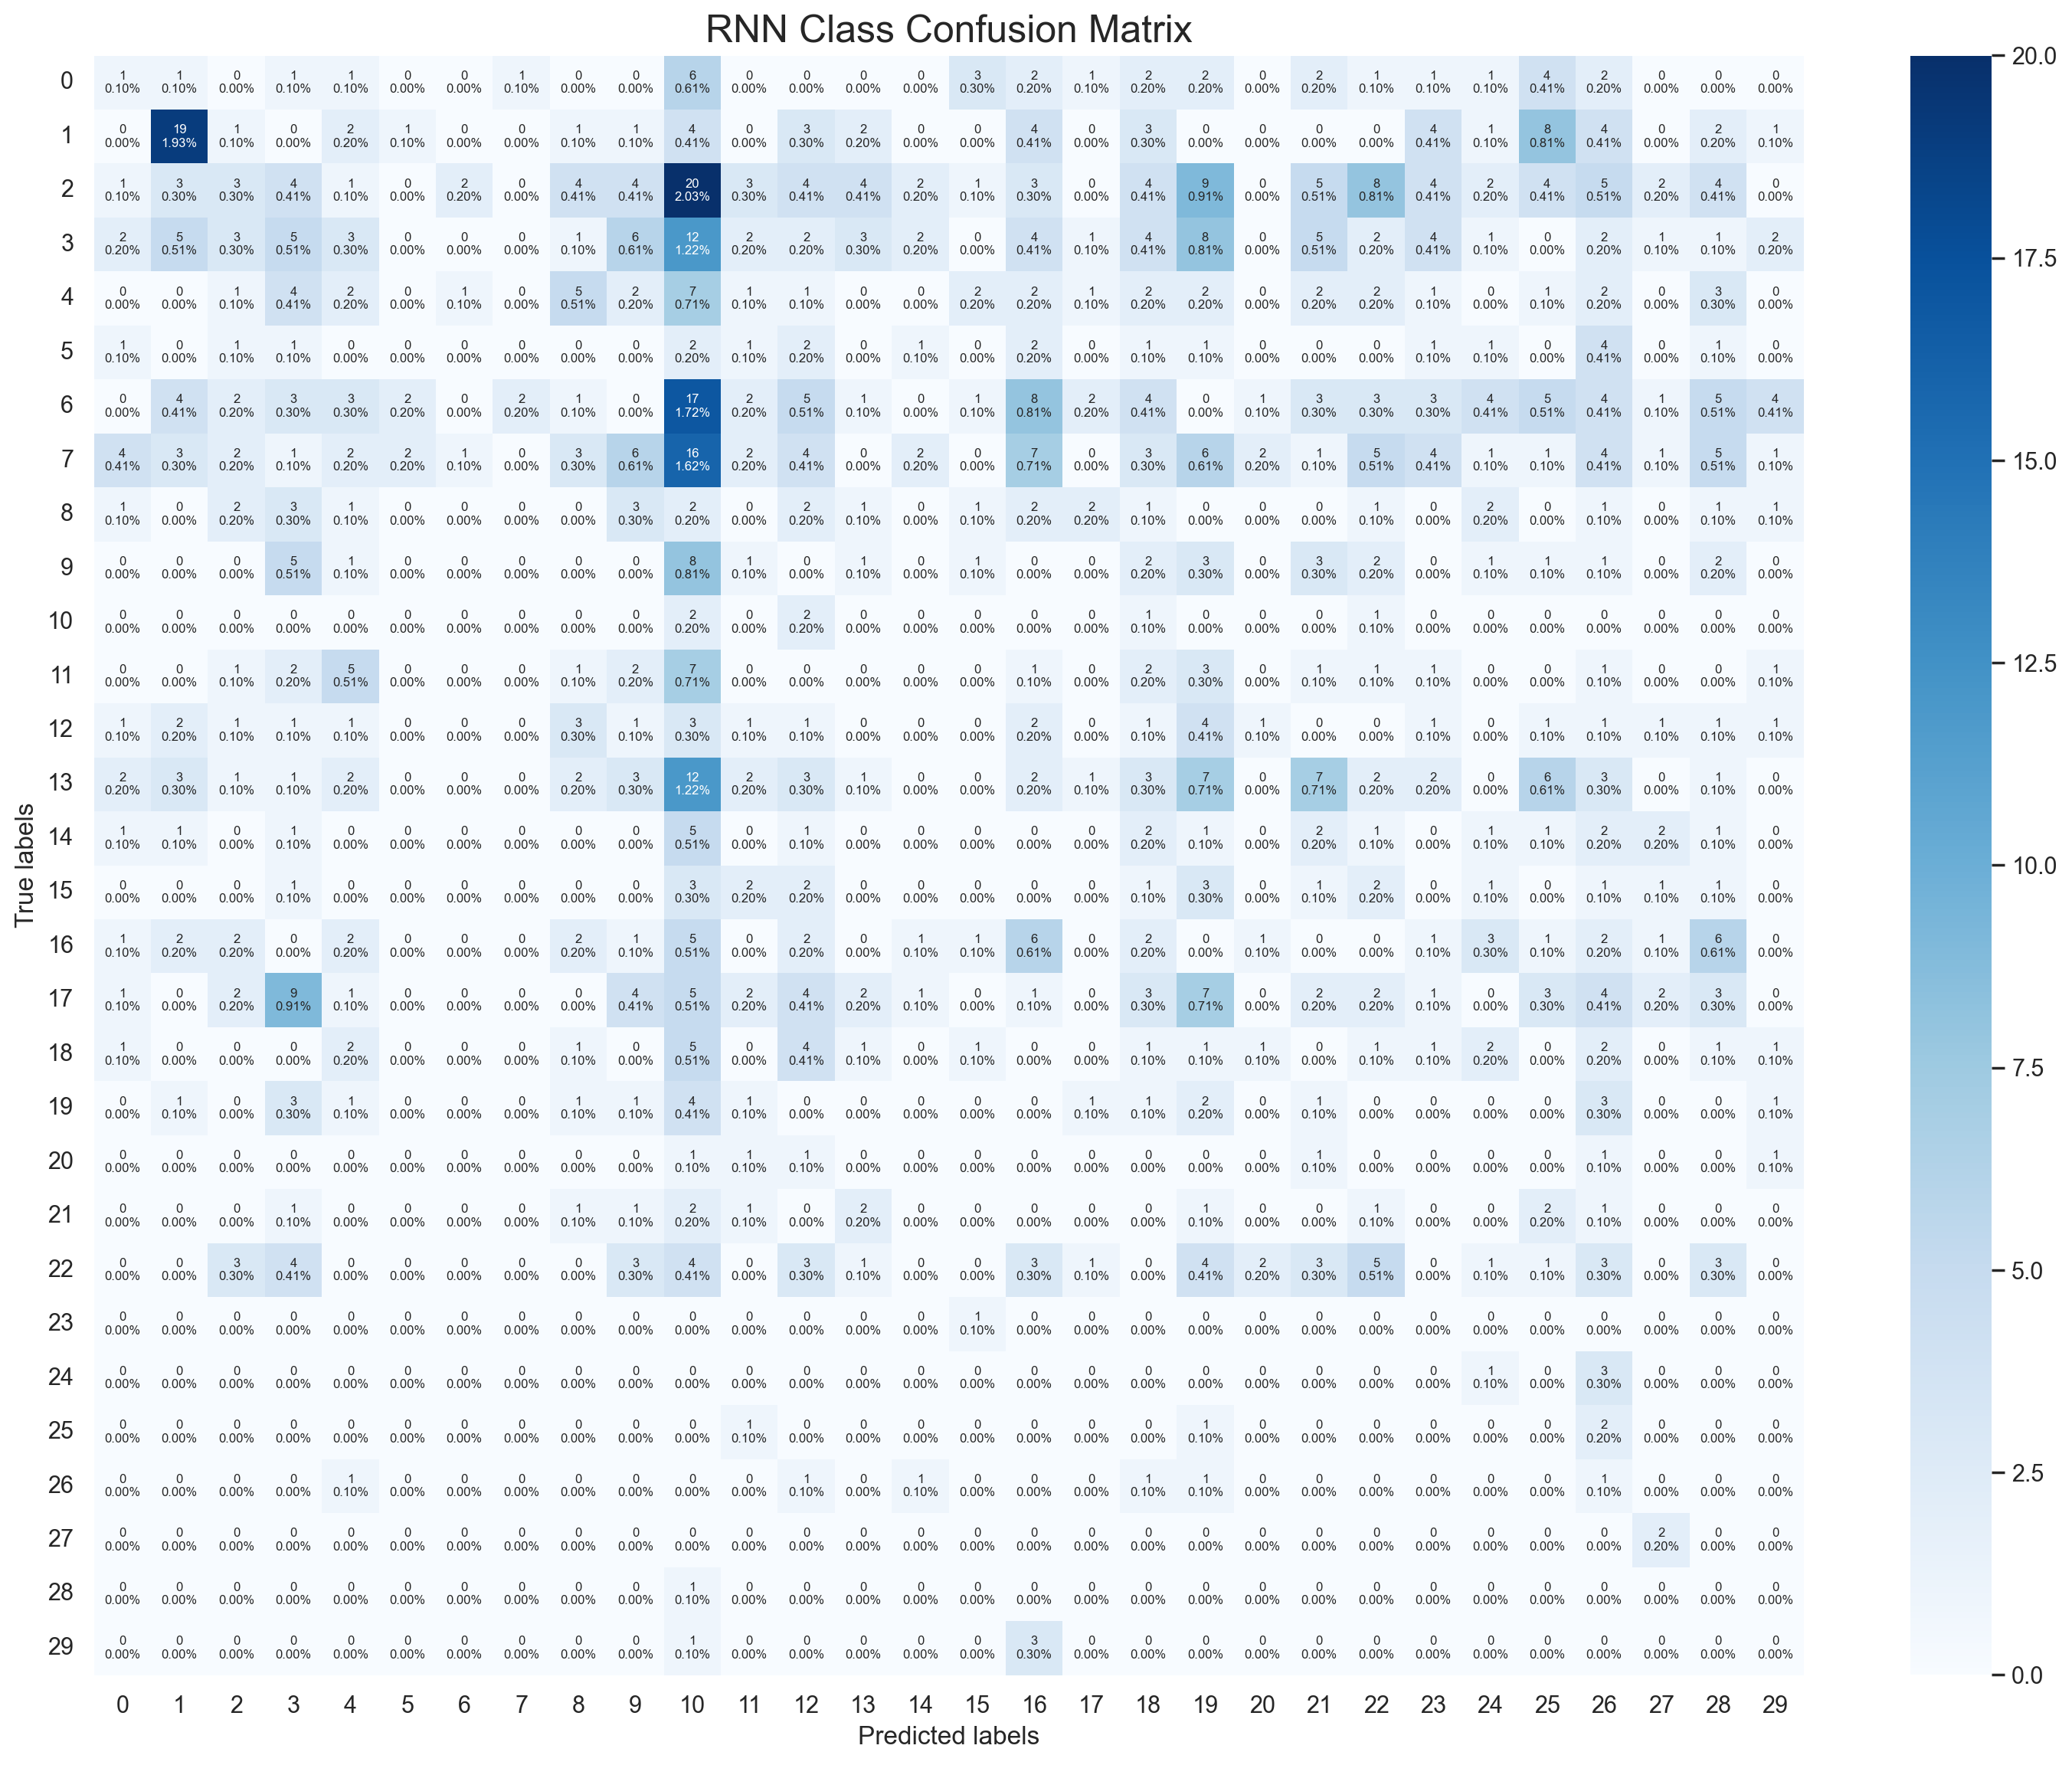

In [30]:
model = load_model_from_file("model_storage/RNN/filterd_words/")

## GRU: Top 10 Filtered TF-IDF Classification 

----------------------------------------------------------------------------------------------------
                                 Model Outcomes: GRU filterd_words
---------------------------------------------------------------------------------------------------- 

GRU  Accuracy Score:  6.59%
GRU  Precision Score:  11.69%
GRU  Recall Score:  6.59%
GRU  F1 Score:  6.92%
----------------------------------------------------------------------------------------------------
                                       Classification Report
---------------------------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.17      0.03      0.05        32
           1       0.88      0.23      0.36        61
           2       0.15      0.10      0.12       106
           3       0.17      0.14      0.15        81
           4       0.00      0.00      0.00        44
           5       0.04      0.25

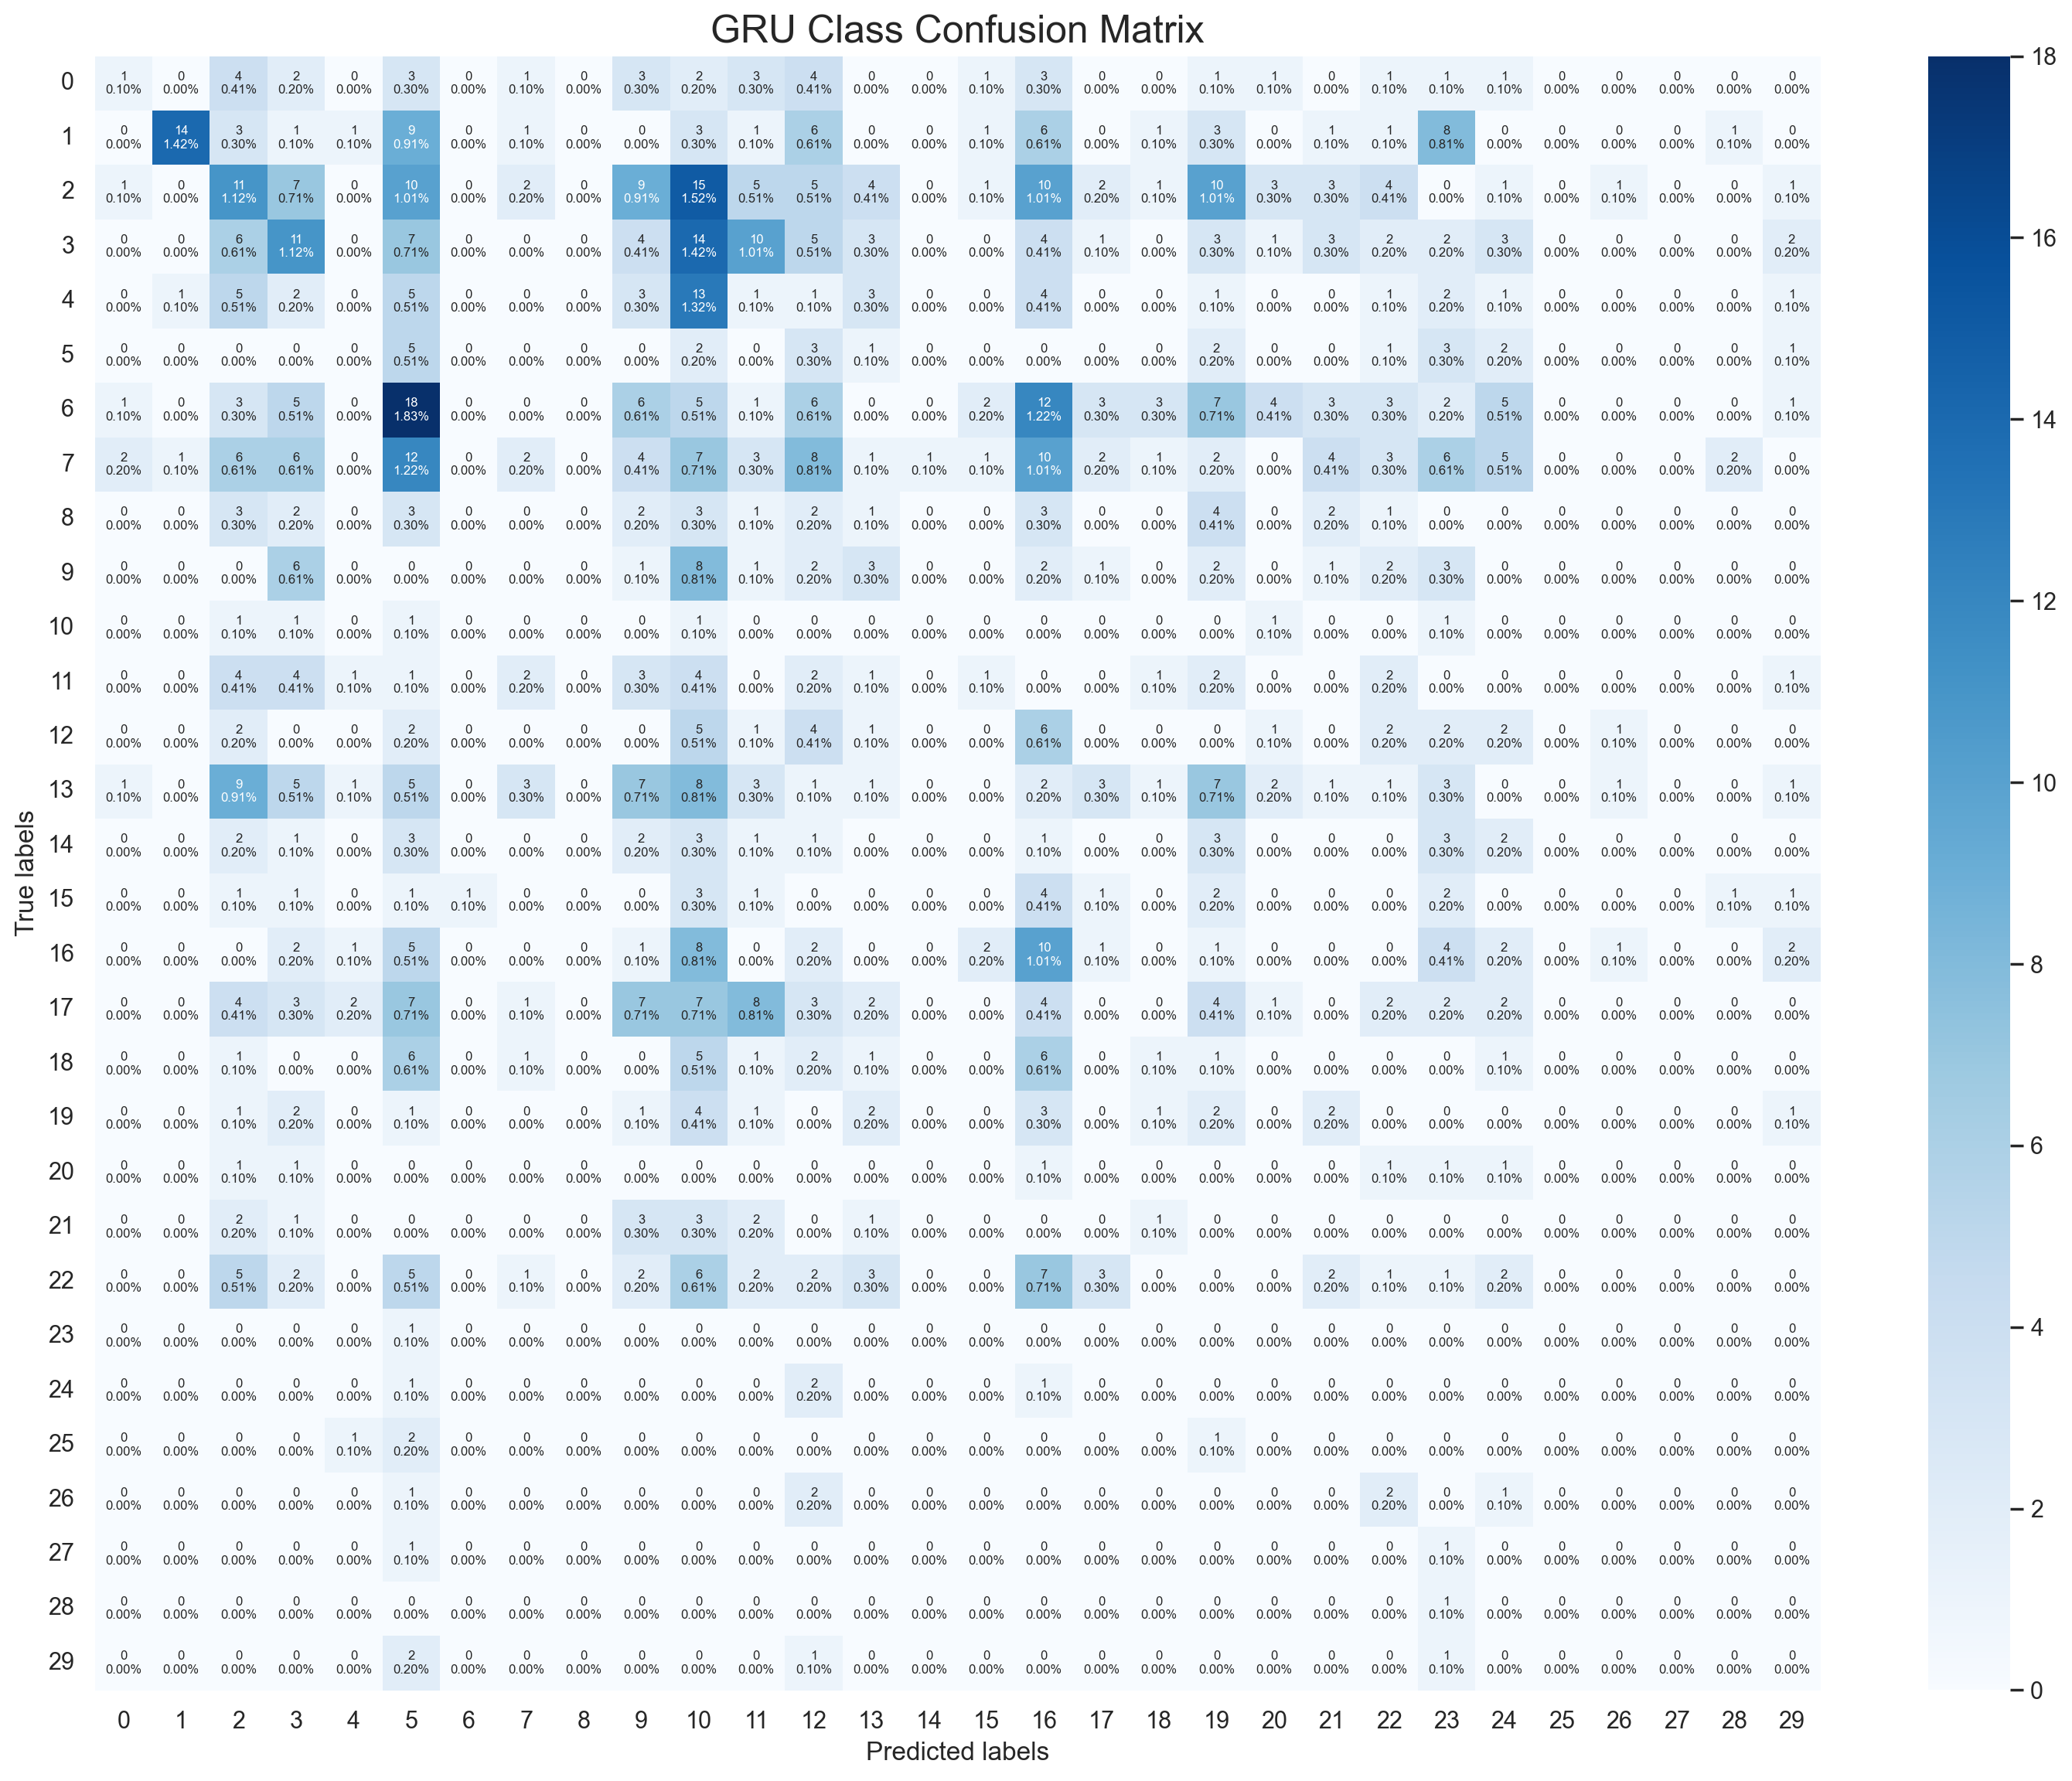

In [31]:
model = load_model_from_file("model_storage/GRU/filterd_words/")

## LSTM: Top 10 Filtered TF-IDF Classification 

----------------------------------------------------------------------------------------------------
                                 Model Outcomes: LSTM filterd_words
---------------------------------------------------------------------------------------------------- 

LSTM  Accuracy Score:  7.10%
LSTM  Precision Score:  9.27%
LSTM  Recall Score:  7.10%
LSTM  F1 Score:  7.46%
----------------------------------------------------------------------------------------------------
                                       Classification Report
---------------------------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.17      0.03      0.05        32
           1       0.49      0.41      0.45        61
           2       0.11      0.06      0.07       106
           3       0.14      0.12      0.13        81
           4       0.00      0.00      0.00        44
           5       0.11      

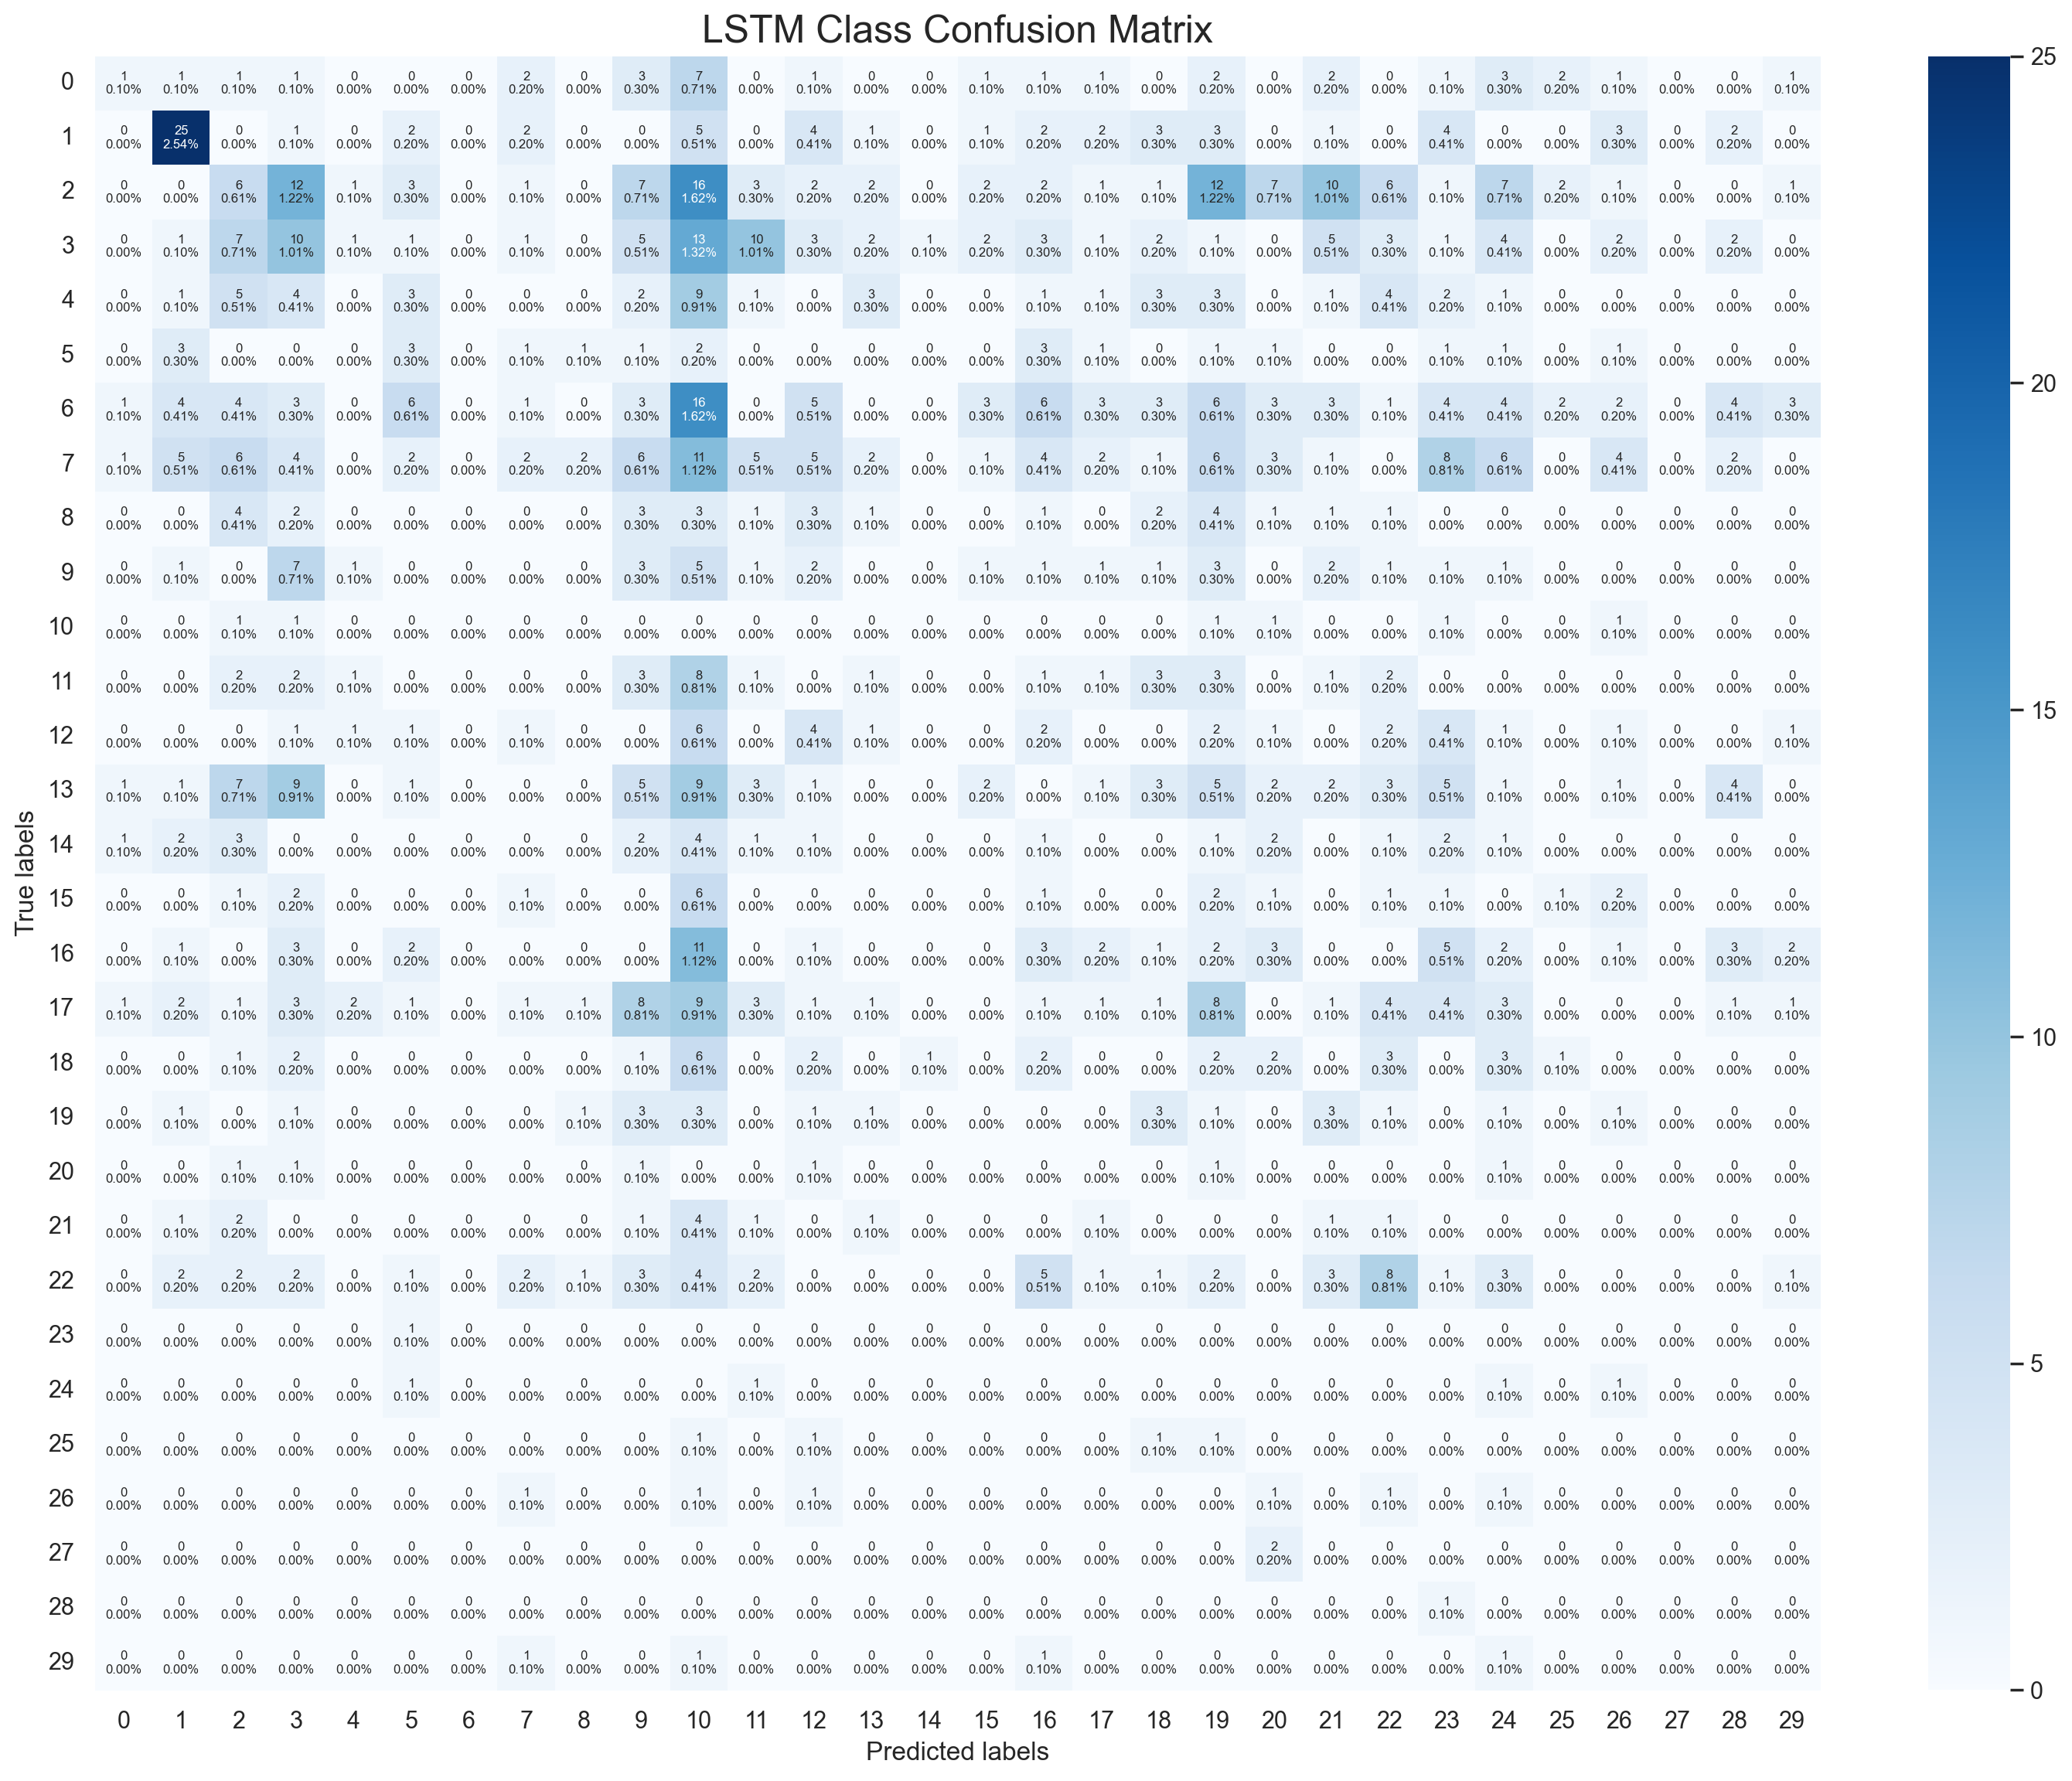

In [32]:
model = load_model_from_file("model_storage/LSTM/filterd_words/")